<a href="https://colab.research.google.com/github/supsi-dacd-isaac/teaching/blob/main/2021SmartGrids/L05_Power_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Flow Simulations
In this lecture we will solve a power flow for the following circuit

<center><img src="https://github.com/supsi-dacd-isaac/teaching/raw/main/2021SmartGrids/figs/load_flow_circuit.png" width="600"></center>

using the Gauss-Seidel method.

We know the impedances of the lines:
$$
\begin{array}{l}
\bar{Z}_1 = 0.05 + 0.1j\\
\bar{Z}_2 = 0.05 + 0.05j\\
\bar{Z}_3 = 0.15 + 0.2j\\
\bar{Z}_4 = 0.04 + 0.12j
\end{array}
$$

Let us further assume that buses 1 and 2 are generators with the ability to modulate their reactive power. We then consider the modulus of their voltages to be constant and equal to :
$$
\begin{array}{l}
E_1 = 1.05 \mathrm{pu}\\
E_2 = 1.00 \mathrm{pu}\\
\end{array}
$$
And their active powers $P_1,P_2 = 1  \mathrm{pu}$

Let us assume that Buses 3 and 4 are loads. Let us consider their potentials (complex vectors) unknown, and let us consider their powers known:
$$
\begin{array}{l}
P3 = -0.9 \mathrm{pu}, Q3 = 0 \mathrm{pu}\\
P4 = -1 \mathrm{pu}, Q4 = -0.2 \mathrm{pu}\\
\end{array}
$$

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Let's define the grid parameters in terms of the m line impedances, and plot them as complex vectors.

Text(0, 0.5, 'Imag (z)')

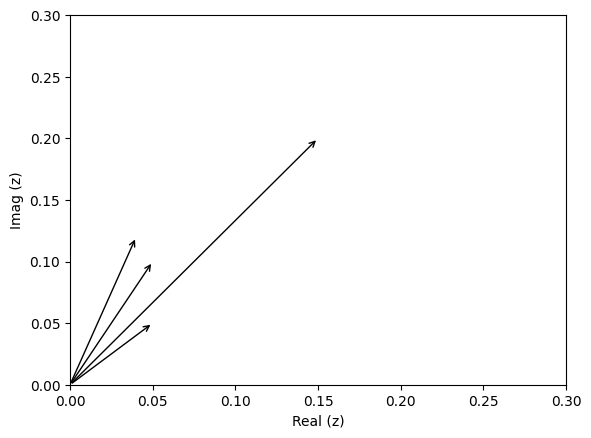

In [75]:
Z = np.array([.05 + .1j,
              .05 + .05j,
              .15 + .2j,
              .04 + .12j])

fig, ax = plt.subplots(1, 1)
[ax.annotate('', xy=(x.real, x.imag), xytext=(0, 0), arrowprops=dict(arrowstyle="->")) for i, x in enumerate(Z)]
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.xlabel('Real (z)')
plt.ylabel('Imag (z)')

The second element we need to characterize our grid is the incidence matrix I, having n rows and m columns, where n is the number of nodes in the grid and m the number of branches. The incidence matrix is an alternative to the adiacence matrix to describe the topology of the grid. We can plot the resulting connections using networkx.

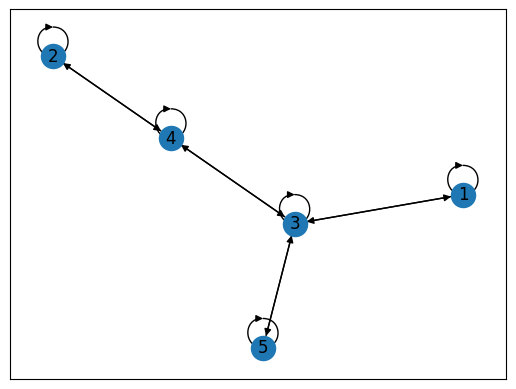

In [76]:
NI = np.asanyarray([[1, 0, 0, 0],
                    [0, 0, 0, 1],
                    [-1, 1, -1, 0],
                    [0, 0, 1, -1],
                    [0, -1, 0, 0]], dtype=int)

NI_abs = np.abs(NI)
adjacency = NI_abs @ NI_abs.T
graph = nx.DiGraph(np.array(adjacency))
graph = nx.relabel_nodes(graph, lambda x: x + 1)

positions = nx.kamada_kawai_layout(graph)
nx.draw_networkx(graph, pos=positions)

In [77]:
# let's define vectors of known voltages magnitudes and angles

# starting values for voltages' magnitudes and angles
EM = np.array([1.05, 1, 1, 1, 1]).reshape(-1, 1)
EA = np.array([0, 0, 0, 0, 0]).reshape(-1, 1)

# let's create boolean vectors indicating which voltage magnitudes and angles
# are to use in the error checking phase of the iterations
EMK = np.array([1, 1, 0, 0, 1], dtype=bool).reshape(-1, 1)
EAK = np.array([0, 0, 0, 0, 1], dtype=bool).reshape(-1, 1)

# let's define known active and reactive powers, and put 0 if they're not known
P = np.array([1, 1, -.9, -1, 0]).reshape(-1, 1)
Q = np.array([0, 0, 0, -.2, 0]).reshape(-1, 1)

# let's create boolean vectors indicating which active and reactive powers
# are to use in the error checking phase of the iterations
PK = np.array([1, 1, 1, 1, 0]).reshape(-1, 1)
QK = np.array([0, 0, 1, 1, 0]).reshape(-1, 1)

We can now define the admittance matrix from the line admittance matrix.

In [78]:
YL = np.diag(1 / Z)
print('YL: {}'.format(YL))
Y = NI @ YL @ NI.T  # <------- fill this
print('Y: {}'.format(Y))

YL: [[ 4.  -8.j   0.  +0.j   0.  +0.j   0.  +0.j ]
 [ 0.  +0.j  10. -10.j   0.  +0.j   0.  +0.j ]
 [ 0.  +0.j   0.  +0.j   2.4 -3.2j  0.  +0.j ]
 [ 0.  +0.j   0.  +0.j   0.  +0.j   2.5 -7.5j]]
Y: [[  4.  -8.j    0.  +0.j   -4.  +8.j    0.  +0.j    0.  +0.j ]
 [  0.  +0.j    2.5 -7.5j   0.  +0.j   -2.5 +7.5j   0.  +0.j ]
 [ -4.  +8.j    0.  +0.j   16.4-21.2j  -2.4 +3.2j -10. +10.j ]
 [  0.  +0.j   -2.5 +7.5j  -2.4 +3.2j   4.9-10.7j   0.  +0.j ]
 [  0.  +0.j    0.  +0.j  -10. +10.j    0.  +0.j   10. -10.j ]]


### Load flow solutions
In order to retrieve a good solution for the power flow, we must pick reasonable starting values for the nodal voltages and angles. Even if the algorithm that we're gonna use is guaranteed to converge, the final solution isn't guaranteed to be the correct one. Generally speaking, we can choose voltage values close to unity since we are solving the power flow in per unit, and we can choose small deviations for the voltage angles.

In [79]:
def solve_lf(NI, Y, YL, EM, EA, EMK, EAK, Pstar, Qstar, PK, QK, tol=1e-6):
    """
    Solve approximated load flow
    """

    # error initialization
    Error = 1
    N = len(EM)

    # complex voltage
    E = EM * np.exp(1j * EA);

    # counter initialization
    r = 1
    Errors = []
    while Error > tol:
        E_prev = E.copy()
        for i in range(N):  # iterate over all nodes
            # the solution method depends on the node type
            if ~EMK[i] and ~EAK[i]:  # if it's a load
                I_conj = (Pstar[i] - 1j * Qstar[i]) / np.conj(E[i])
                for n in range(N):
                    if n != i:
                        I_conj = I_conj - (Y[i, n] * E[n])
                E[i] = I_conj / Y[i, i]
            elif EMK[i] and ~EAK[i]:  # if it's a generator
                Ii = Y[[i], :] @ E
                Qi = -np.imag(np.conj(E[i]) @ Ii)
                pvc = (Pstar[i] - 1j * Qi) / np.conj(E[i])
                for n in range(N):
                    if n != i:
                        pvc = pvc - (Y[i, n] * E[n])
                pv = pvc / Y[i, i]
                E[i] = EM[i] @ np.exp(1j * np.angle(pv))

        # recompute nodal currents
        I = (Y @ E)

        # recompute powers
        P = np.real(E * np.conj(I))
        Q = np.imag(E * np.conj(I))

        step = np.abs(E)-np.abs(E_prev)
        # let's recompute current solutions' distances from known quantities
        PERR = (Pstar - P) * PK
        QERR = (Qstar - Q) * QK
        Error = np.sum(np.abs(PERR) ** 2 + np.abs(QERR) ** 2)
        Errors.append(Error)
        r = r + 1
    DVline = NI.T @ E
    I = Y @ E
    Iline = YL @ DVline
    Sloss = DVline * np.conj(Iline)
    return E, P, Q, I, DVline, Iline, Sloss, Errors

In [80]:
E, P, Q, I, DVline, Iline, Sloss, errs = solve_lf(NI, Y, YL, EM, EA, EMK, EAK, P, Q, PK, QK, tol=1e-9)

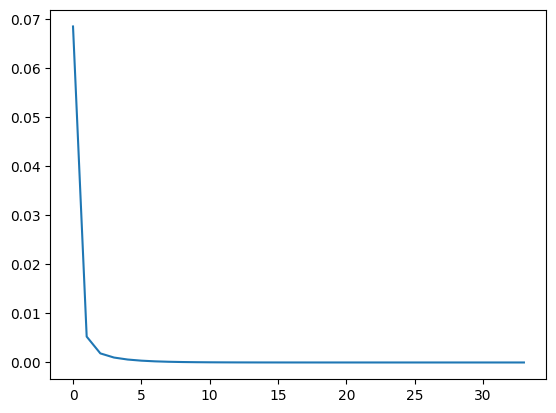

In [81]:
plt.plot(errs)

E: {1: 1.0499999999999998, 2: 1.0, 3: 0.9933146554300005, 4: 0.9494099856059035, 5: 1.0}
P: {1: 0.9999879241639494, 2: 0.9999753308894329, 3: -0.9000090170551808, 4: -0.9999996745645323, 5: -0.006431996443694743}
Q: {1: 0.13688622345137377, 2: 0.14567246173571932, 3: 4.9481691337382215e-06, 4: -0.20000285681418803, 5: 0.1406836119864785}


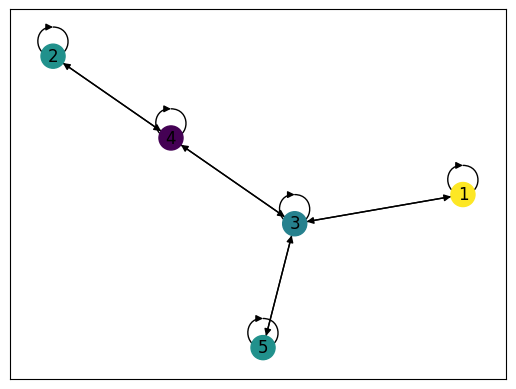

In [84]:
nx.set_node_attributes(graph, {k: v for k, v in zip(graph.nodes, np.abs(E).ravel())}, 'v')
nx.set_node_attributes(graph, {k: v for k, v in zip(graph.nodes, P.ravel())}, 'p')
nx.set_node_attributes(graph, {k: v for k, v in zip(graph.nodes, Q.ravel())}, 'q')
nx.draw_networkx(graph, node_color=list(nx.get_node_attributes(graph, 'v').values()), pos=positions)
print('E: {}'.format(nx.get_node_attributes(graph, 'v')))
print('P: {}'.format(nx.get_node_attributes(graph, 'p')))
print('Q: {}'.format(nx.get_node_attributes(graph, 'q')))